In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

priors = np.array([0.65, 0.35])
weights = np.array([.5, .5])
class0_mean = np.array([[3,0],[0,3]])
class0_cov = np.array([[[2,0],[0,1]],[[1,0],[0,2]]])
class1_mean = np.array([2,2])
class1_cov = np.array([[1,0],[0,1]])

In [42]:
def generateData(numsamples):
    classes = np.where(np.random.rand(numsamples) >= .65, 1, 0)    
    data = np.empty((numsamples,2))

    for i in range(numsamples):
        if(classes[i] == 1):
            data[i] = np.random.multivariate_normal(class1_mean, class1_cov)
        else:
            rand = np.random.rand()
            subclass = 1 if rand>weights[0] else 0
            data[i] = np.random.multivariate_normal(class0_mean[subclass], class0_cov[subclass])
           
    return data, classes

C:\Users\meuli\AppData\Local\Temp\ipykernel_34556\2016048545.py:39: UserWarning: No contour levels were found within the data range.
  plt.contour(a[0],a[1],dsg, levels = [0])


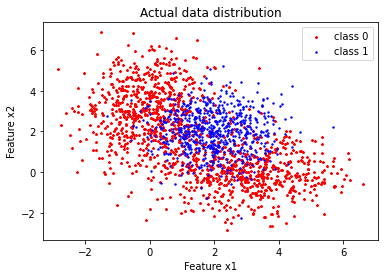

In [43]:
D20_train_data, D20_train_labels = generateData(20)
D200_train_data, D200_train_labels = generateData(200)
D2000_train_data, D2000_train_labels = generateData(2000)
D10k_validate_data, D10k_validate_labels = generateData(10000)

# I added below to plot the raw data
X = D2000_train_data
labels = D2000_train_labels
samples = 2000

x0 = [i for i in range(0,samples) if(labels[i] == 0)]
x1 = [i for i in range(0,samples) if(labels[i] == 1)]
plt.scatter(X.T[0,x0],X.T[1,x0],s=5, color = 'red', label = 'class 0',marker='*')
plt.scatter(X.T[0,x1],X.T[1,x1],s=2, color = 'blue', label = 'class 1',marker='o')
plt.title("Actual data distribution")
plt.xlabel("Feature x1")
plt.ylabel("Feature x2")
plt.legend()


(2, 10000)


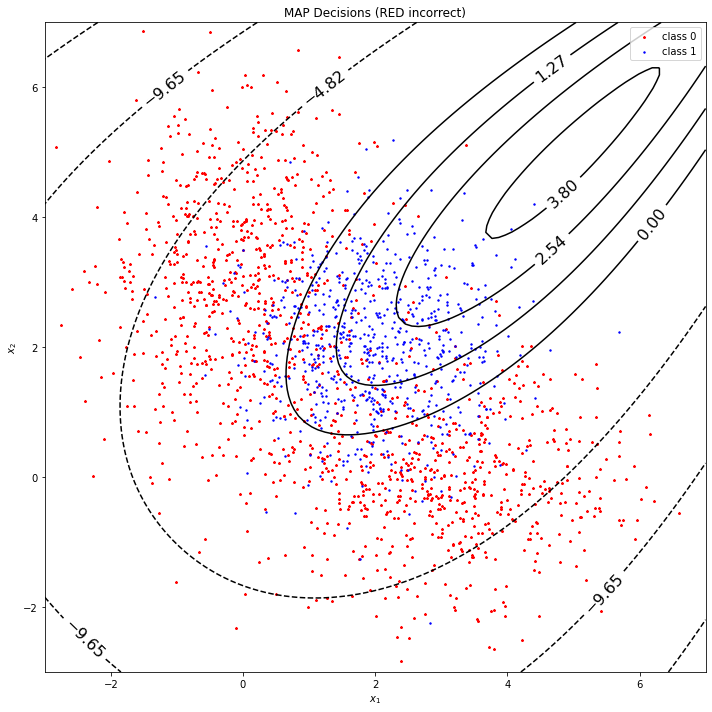

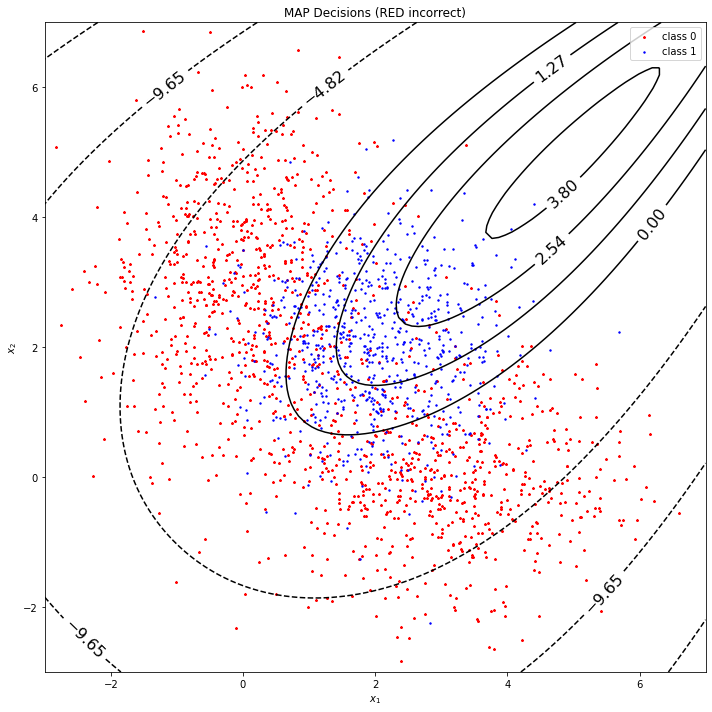

In [46]:
labels = D2000_train_labels
samples = 2000

x0 = [i for i in range(0,samples) if(labels[i] == 0)]
x1 = [i for i in range(0,samples) if(labels[i] == 1)]

fig_disc_grid, ax_disc = plt.subplots(figsize=(10, 10));
# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.scatter(X.T[0,x0],X.T[1,x0],s=5, color = 'red', label = 'class 0',marker='*')
ax_disc.scatter(X.T[0,x1],X.T[1,x1],s=2, color = 'blue', label = 'class 1',marker='o')

ax_disc.legend();
ax_disc.set_xlabel(r"$x_1$");
ax_disc.set_ylabel(r"$x_2$");
ax_disc.set_title("MAP Decisions (RED incorrect)");
fig_disc_grid.tight_layout();

horizontal_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])

class0_condprob_ = weights[0]*multivariate_normal.pdf(gridxy.T, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(gridxy.T, class0_mean[1], class0_cov[1])
class1_condprob_ = multivariate_normal.pdf(gridxy.T, class1_mean, class1_cov)

likelihood_grid_vals = np.array([class0_condprob_, class1_condprob_])
# Where a score of 0 indicates decision boundary level
print(likelihood_grid_vals.shape)
gamma_map = priors[0]/priors[1]
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

plt.show()
fig_disc_grid

In [ ]:
def class1_condprob(x):
    return multivariate_normal.pdf(x, class1_mean, class1_cov)    

def class0_condprob(x):
    return weights[0]*multivariate_normal.pdf(x, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(x, class0_mean[1], class0_cov[1])
    
def classifyBayesian(data, priors):
    classcond_matrix = np.column_stack((class0_condprob(data), class1_condprob(data)))
    posteriors = np.multiply(np.transpose(priors), classcond_matrix)
    return np.argmax(posteriors, axis=1)

def classifyByLikelihoodRatio(data, gamma):
    likelihoodratios = np.divide(class1_condprob(data), class0_condprob(data))
    return np.where(likelihoodratios > gamma, 1, 0)

def calculateROCVectors(results, truelabels):
    truepoz = np.sum(np.logical_and(truelabels, results))/results.size
    falsepoz = np.sum(np.logical_and(np.logical_not(truelabels), results))/results.size
    return falsepoz, truepoz

def calculate_correct_rate(classifiedlabels, correctlabels):
    return np.sum(np.equal(classifiedlabels, correctlabels))/classifiedlabels.size*100
    
def calculate_error_rate(classifiedlabels, correctlabels):
    return 100-calculate_correct_rate(classifiedlabels, correctlabels)

0.1660259852358239
0.1196767174386074
Optimum Gamma:  1.8571428571428574
16.730000000000004
0.1664070755281942


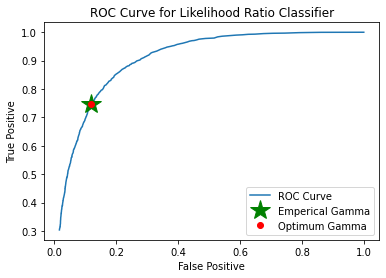

In [31]:
x = D10k_validate_data

class0_condprob_ = weights[0]*multivariate_normal.pdf(x, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(x, class0_mean[1], class0_cov[1])
class1_condprob_ = multivariate_normal.pdf(x, class1_mean, class1_cov)

classcond_matrix = np.column_stack((class0_condprob_, class1_condprob_))
posteriors = np.multiply(np.transpose(priors), classcond_matrix)
D10k_classifier_results =  np.argmax(posteriors, axis=1)

# -------------

testgammas = np.arange(0, 10, .01)
falsepoz = np.empty(testgammas.shape[0])
truepoz = np.empty(testgammas.shape[0])

Nlabels = np.array((sum(D10k_validate_labels == 0), sum(D10k_validate_labels == 1)))
for i in range(testgammas.shape[0]):
    gamma = testgammas[i]
  
    likelihoodratios = np.divide(class1_condprob_, class0_condprob_)
    classifier_results = np.where(likelihoodratios > gamma, 1, 0)

    results = classifier_results
    truelabels = D10k_validate_labels

    truepoz[i] = np.sum(np.logical_and(truelabels, results))/Nlabels[1]
    falsepoz[i] = np.sum(np.logical_and(np.logical_not(truelabels), results))/Nlabels[0]

prob_error = [(falsepoz[w] *priors[0] + (1 - truepoz[w])* priors[1]) for w in range(len(falsepoz))]
# Find minimum error and index
minimum_error = min(prob_error)
minimum_index = prob_error.index(minimum_error)
print(minimum_error)
print(falsepoz[minimum_index])

plt.plot(falsepoz, truepoz, label="ROC Curve")
plt.plot(falsepoz[minimum_index], truepoz[minimum_index], 'g*', label="Emperical Gamma", markersize=20)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC Curve for Likelihood Ratio Classifier")

optimumgamma = priors[0]/priors[1]
print("Optimum Gamma: ", optimumgamma)

optimumresults = np.where(likelihoodratios > optimumgamma, 1, 0)
optimumtrue = np.sum(np.logical_and(D10k_validate_labels, optimumresults))/Nlabels[1]
optimumfalse = np.sum(np.logical_and(np.logical_not(D10k_validate_labels), optimumresults))/Nlabels[0]

#optimumfalse, optimumtrue = calculateROCVectors(optimumresults, D10k_validate_labels)

plt.plot(optimumfalse, optimumtrue, 'ro', label="Optimum Gamma")
plt.legend()

optimumperformancerate = np.sum(np.equal(optimumresults, D10k_validate_labels))/D10k_validate_labels.size*100
print(100-optimumperformancerate)

optimumtrue1 = np.logical_and(D10k_validate_labels, optimumresults)
prob_error = optimumfalse *priors[0] + (1 - optimumtrue)* priors[1]
print(prob_error)

In [47]:
# # Part 1
# D10k_classifier_results = classifyBayesian(D10k_validate_data, priors)

# testgammas = np.arange(0, 10, .01)
# falsepoz = np.empty(testgammas.shape[0])
# truepoz = np.empty(testgammas.shape[0])
# for i in range(testgammas.shape[0]):
#     classifier_results = classifyByLikelihoodRatio(D10k_validate_data, testgammas[i])
#     falsepoz[i], truepoz[i] = calculateROCVectors(classifier_results, D10k_validate_labels)

# plt.plot(falsepoz, truepoz, label="ROC Curve")
# plt.xlabel("False Positive")
# plt.ylabel("True Positive")
# plt.title("ROC Curve for Likelihood Ratio Classifier")

# optimumgamma = priors[0]/priors[1]
# optimumresults = classifyByLikelihoodRatio(D10k_validate_data, optimumgamma)
# optimumfalse, optimumtrue = calculateROCVectors(optimumresults, D10k_validate_labels)

# plt.plot(optimumfalse, optimumtrue, 'ro', label="Optimum Gamma")
# plt.legend()

# optimumperformancerate = calculate_correct_rate(optimumresults, D10k_validate_labels)

In [48]:
# Part 2

# Borrowed from https://stackabuse.com/gradient-descent-in-python-implementation-and-theory/
def gradient_descent(max_iterations,threshold,w_init,
                     obj_func,grad_func,
                     learning_rate=0.05, **kwargs):
    
    w = w_init
    w_history = w
    f_history = obj_func(w,**kwargs)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while  i<max_iterations and diff>threshold:
        delta_w = -learning_rate*grad_func(w,**kwargs)
        w = w+delta_w
        
        # store the history of w and f
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,obj_func(w,**kwargs)))
        
        # update iteration number and diff between successive values
        # of objective function
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

def sigmoid(a):
    return 1/(1+np.exp(-a))

# phi should have data columns and parameter rows for this to work
def err_func_gradient(w, **kwargs):
    phi = kwargs['phi']
    labels = kwargs['labels']
    a = w @ phi
    return np.sum(np.multiply(sigmoid(a)-labels, phi), axis = 1)

def err_func(w, **kwargs):
    phi = kwargs['phi']
    labels = kwargs['labels']
    a = w @ phi
    return -np.sum((np.multiply(labels, np.log(sigmoid(a)))+np.multiply((1-labels), np.log(1-sigmoid(a)))), axis=0)

def phi_linear(x):
    return np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1]))

def phi_quadratic(x):
    return np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1], x[:,0]**2, x[:,0]*x[:,1], x[:,1]**2))

def classify_logistic_linear(data, w):
    return np.where(sigmoid(w @ phi_linear(data))> .5, 1, 0)

    
def classify_logistic_quadratic(data, w):
        return np.where(sigmoid(w @ phi_quadratic(data))> .5, 1, 0)
    


d20_linear_w, d20_linear_f = gradient_descent(10000, .01, np.array([1, 0, 0]), err_func, err_func_gradient, learning_rate=.001, phi=phi_linear(D20_train_data), labels=D20_train_labels)
d200_linear_w, d200_linear_f = gradient_descent(10000, .01, np.array([1, 0, 0]), err_func, err_func_gradient, learning_rate=.001, phi=phi_linear(D200_train_data), labels=D200_train_labels)
d2000_linear_w, d2000_linear_f = gradient_descent(10000, .01, np.array([1, 0, 0]), err_func, err_func_gradient,learning_rate=.0001, phi=phi_linear(D2000_train_data), labels=D2000_train_labels)

d20_est_linear_w = d20_linear_w[-1,:]
d200_est_linear_w = d200_linear_w[-1,:]
d2000_est_linear_w = d2000_linear_w[-1,:]

d20est_linear_results = classify_logistic_linear(D10k_validate_data, d20_est_linear_w)
d200est_linear_results = classify_logistic_linear(D10k_validate_data, d200_est_linear_w)
d2000est_linear_results = classify_logistic_linear(D10k_validate_data, d2000_est_linear_w)

d20_quad_w, d20_quad_f = gradient_descent(10000, .01, np.ones(6), err_func, err_func_gradient, learning_rate=.001, phi=phi_quadratic(D20_train_data), labels=D20_train_labels)
d20_est_quad_w = d20_quad_w[-1,:]
d20est_quad_results = classify_logistic_quadratic(D10k_validate_data, d20_est_quad_w)
d200_quad_w, d200_quad_f = gradient_descent(10000, .01, np.zeros(6), err_func, err_func_gradient, learning_rate=.00001, phi=phi_quadratic(D200_train_data), labels=D200_train_labels)
d200_est_quad_w = d200_quad_w[-1,:]
d200est_quad_results = classify_logistic_quadratic(D10k_validate_data, d200_est_quad_w)
d2000_quad_w, d2000_quad_f = gradient_descent(10000, .01, np.zeros(6), err_func, err_func_gradient, learning_rate=.00001, phi=phi_quadratic(D2000_train_data), labels=D2000_train_labels)
d2000_est_quad_w = d2000_quad_w[-1,:]
d2000est_quad_results = classify_logistic_quadratic(D10k_validate_data, d2000_est_quad_w)


C:\Users\meuli\AppData\Local\Temp\ipykernel_34556\3212462116.py:44: RuntimeWarning: divide by zero encountered in log
  return -np.sum((np.multiply(labels, np.log(sigmoid(a)))+np.multiply((1-labels), np.log(1-sigmoid(a)))), axis=0)
C:\Users\meuli\AppData\Local\Temp\ipykernel_34556\3212462116.py:26: RuntimeWarning: invalid value encountered in subtract
  diff = np.absolute(f_history[-1]-f_history[-2])
